### Загрузка библиотек

In [2]:
import pandas as pd;
import numpy as np;
from sklearn.model_selection import train_test_split;
from statsmodels.api import Logit;
from statsmodels.tools.tools import add_constant;
from sklearn import metrics;
from sklearn.preprocessing import OneHotEncoder;
import seaborn as sns;
import matplotlib.pyplot as plt;
import scipy as sp;

from special_cross_tables import relative_cross_tab_by_rows;
from chi_sq_test_parts import simple_chi_sq_test;

# Подготовка и исследоввание данных

### Загрузим массив данных и получим недостающие колонки

In [3]:
data = pd.read_csv('input_data.csv', index_col = 0);
data.head()

,default_days,sex,age,income_level_BYR,registration_date,repayment_date,contract_summ,СВ_30_days,force_contract,real_estate,Education,dependents_count
0,0.0,Female,21.0,912.0,2016-08-27,2018-03-27,1000.0,1.0,0.0,Yes,среднее специальное,0.0
1,1.0,Female,27.0,1045.0,2016-07-08,2017-02-05,196.0,2.0,0.0,Yes,высшее,1.0
2,0.0,Female,55.0,1509.0,2016-08-12,2017-01-10,30.0,8.0,0.0,No,среднее,0.0
3,11.0,Female,40.0,1592.0,2016-09-05,2017-01-03,628.0,1.0,0.0,No,среднее,0.0
4,39.0,Male,24.0,816.0,2016-09-26,2018-05-27,2000.0,0.0,2.0,Yes,среднее специальное,1.0


In [4]:
print("размер входной выборки "  + str(data.shape))

# дефолтом воспринимпется ситуция не платежа более 60 дней
data.loc[data['default_days'] > 60, 'default_60+'] = 1
data.loc[data['default_days'] <= 60, 'default_60+'] = 0

размер входной выборки (125639, 12)


### Сумму кредитного договора не слишком целесообразно использовать в качесве предиктора, лучше использовать размер ежемесячного платежа - создадим его

In [5]:
# приводим даты, которые загрузились как строки к типу 'datetime'
data['registration_date'] = pd.to_datetime(data['registration_date'] )
data['repayment_date'] = pd.to_datetime(data['repayment_date'] )

# получаем на сколько месяцев был рассчитан кредит
data['month_term'] = (data['repayment_date'] - data['registration_date'])/np.timedelta64(1, 'M')

# получаем показатель ежемесячный палатеж
data['monthly_payment'] = data['contract_summ'] / data['month_term']

## Проведем исследование числовых предикторов

выделим те предикторы которые могут быть интерпретированы как число

In [6]:
number_preds = data.columns[(data.dtypes == 'float64') & (np.invert(data.columns.isin(['default_60+', 'default_days'])))]
number_preds

Index(['age', 'income_level_BYR', 'contract_summ', 'СВ_30_days',
       'force_contract', 'dependents_count', 'month_term', 'monthly_payment'],
      dtype='object')

начнем с визуализации - хороший вариант ящик с усами и добавим гистограммы распределения

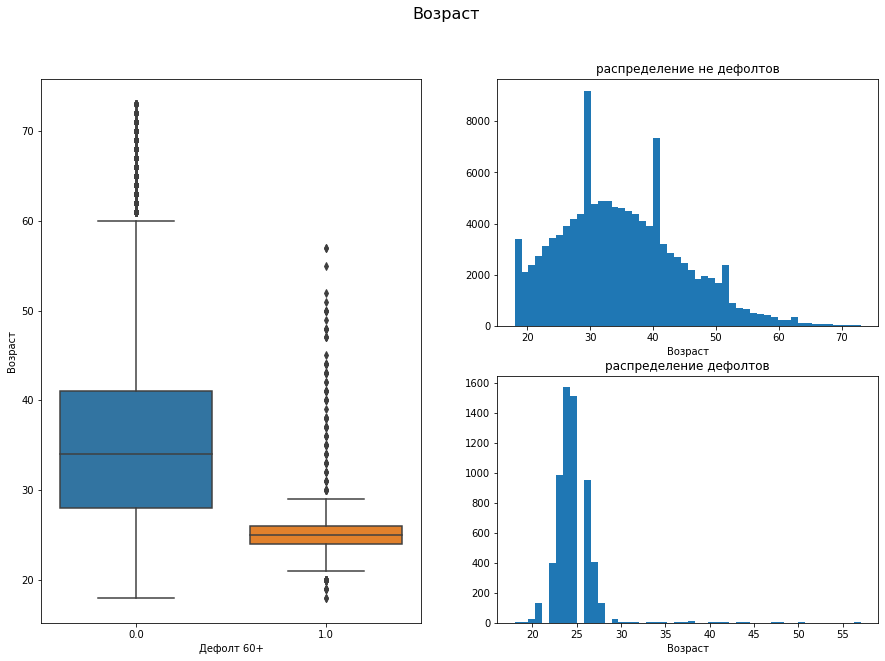

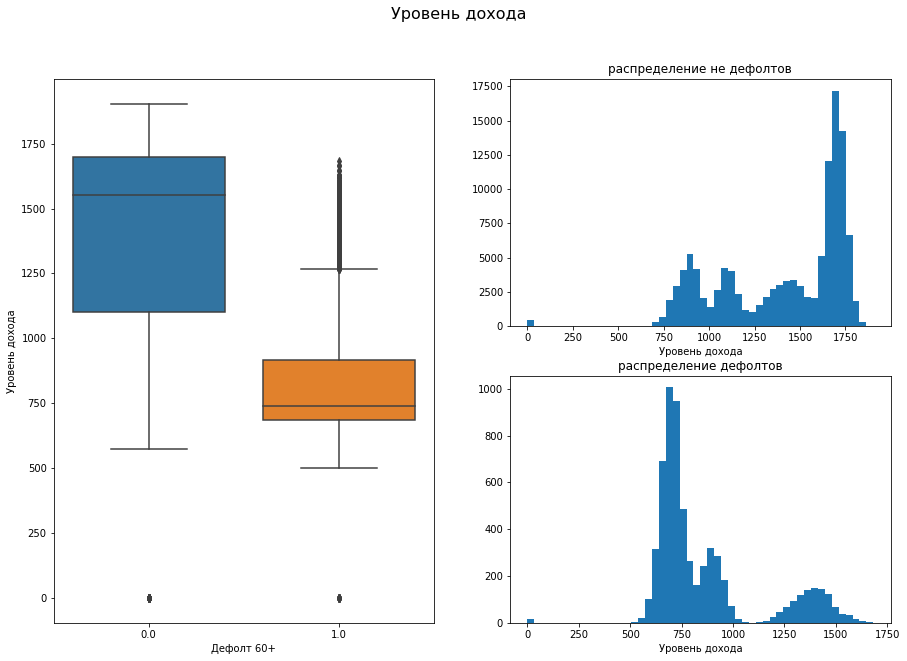

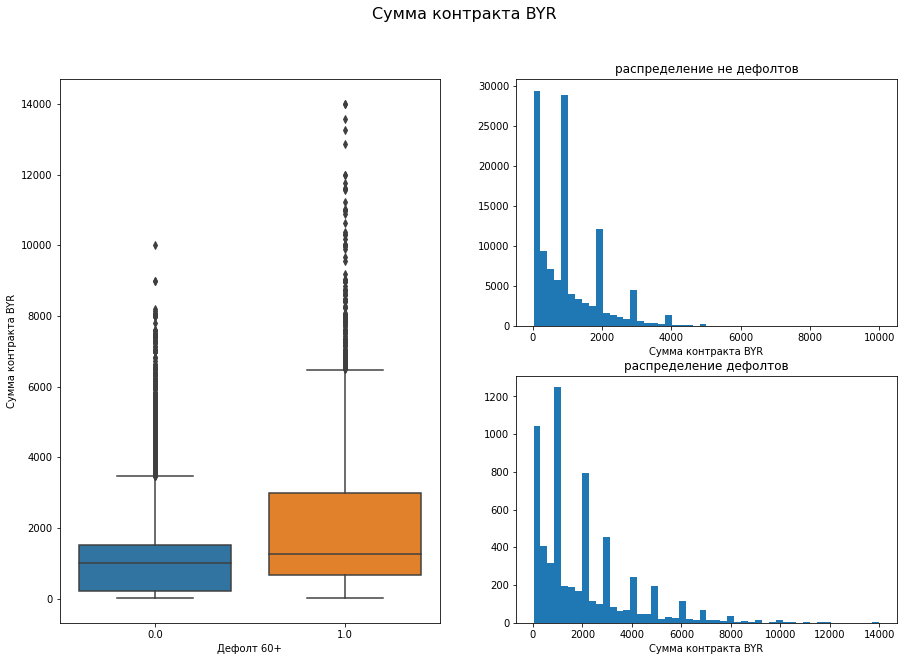

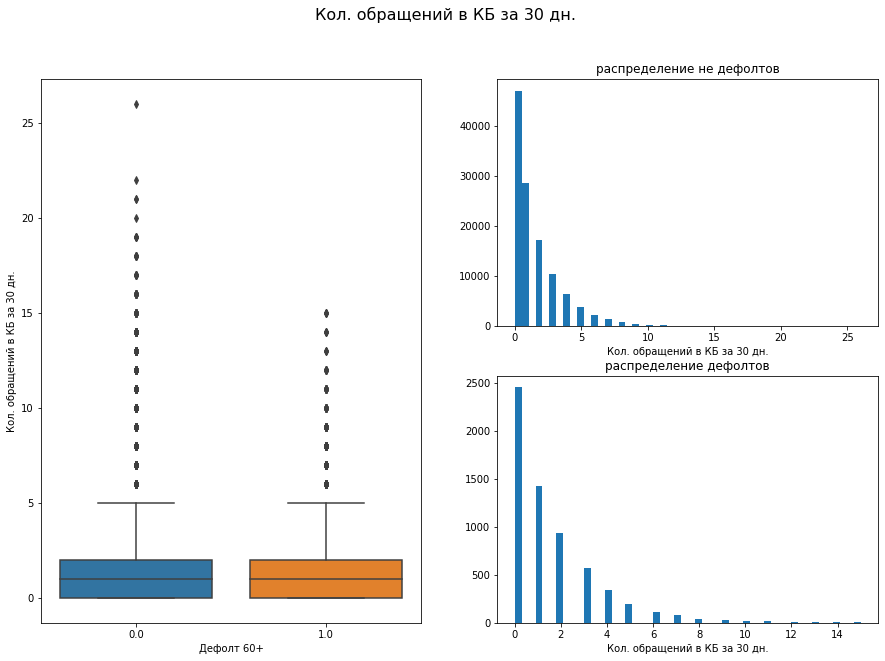

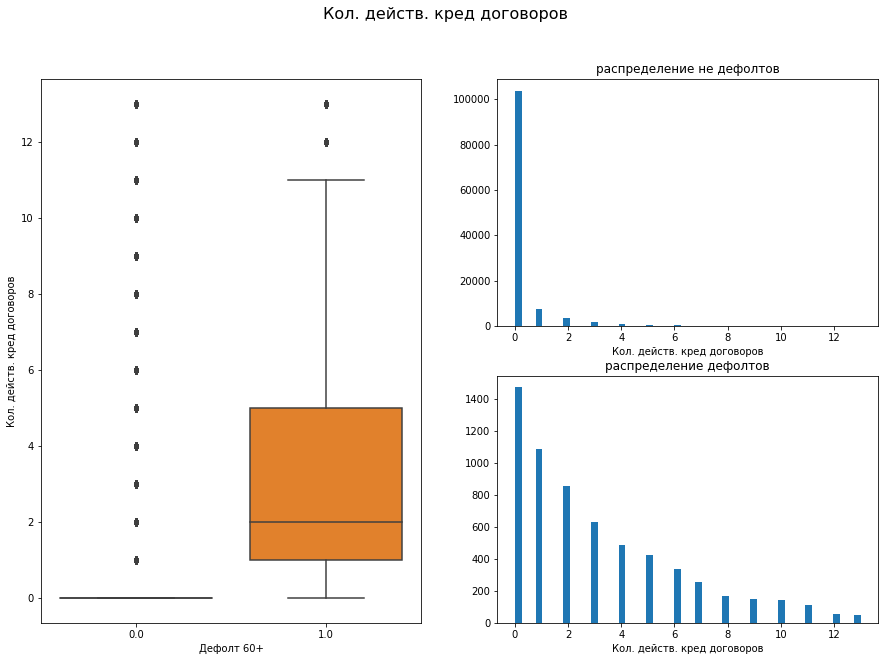

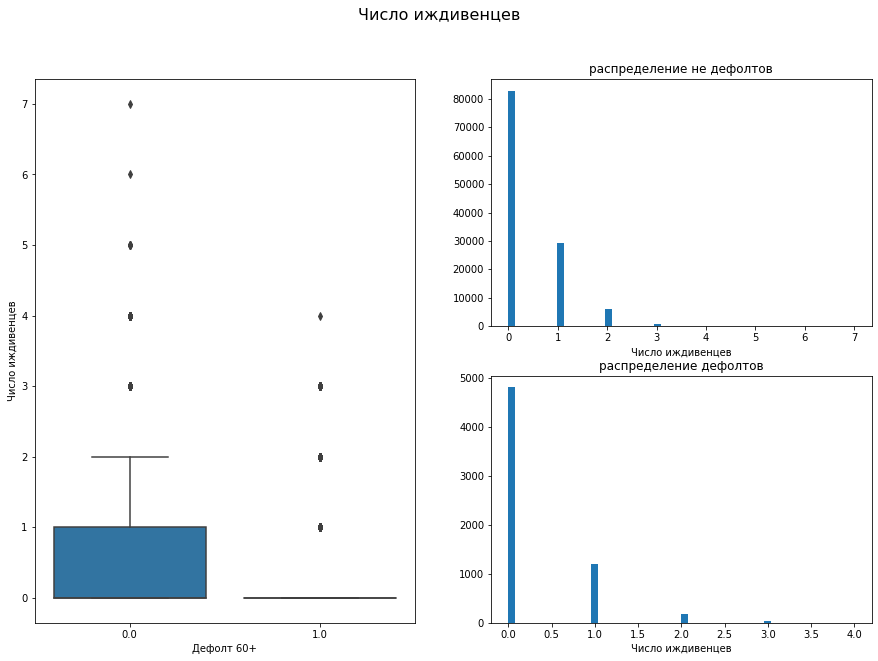

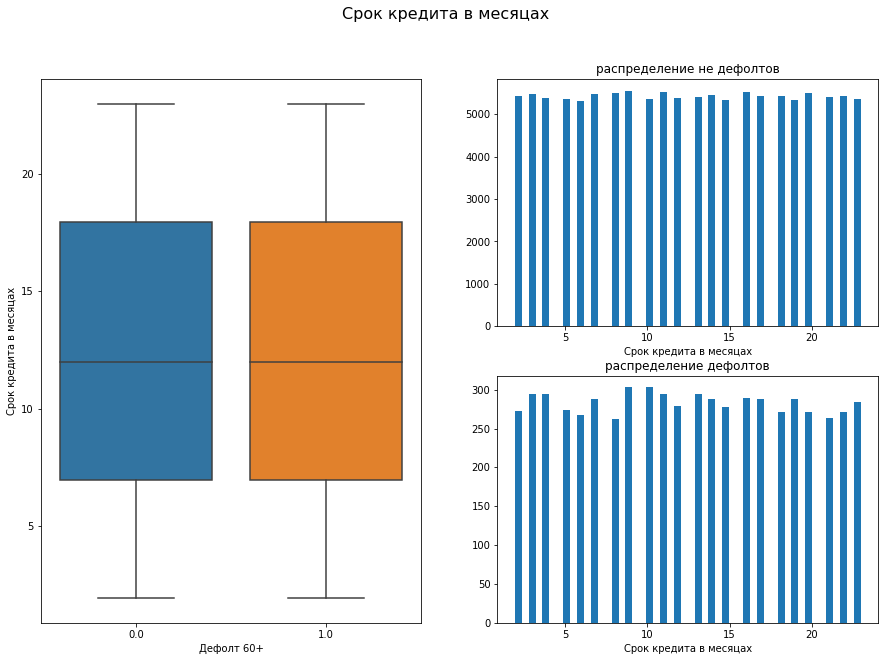

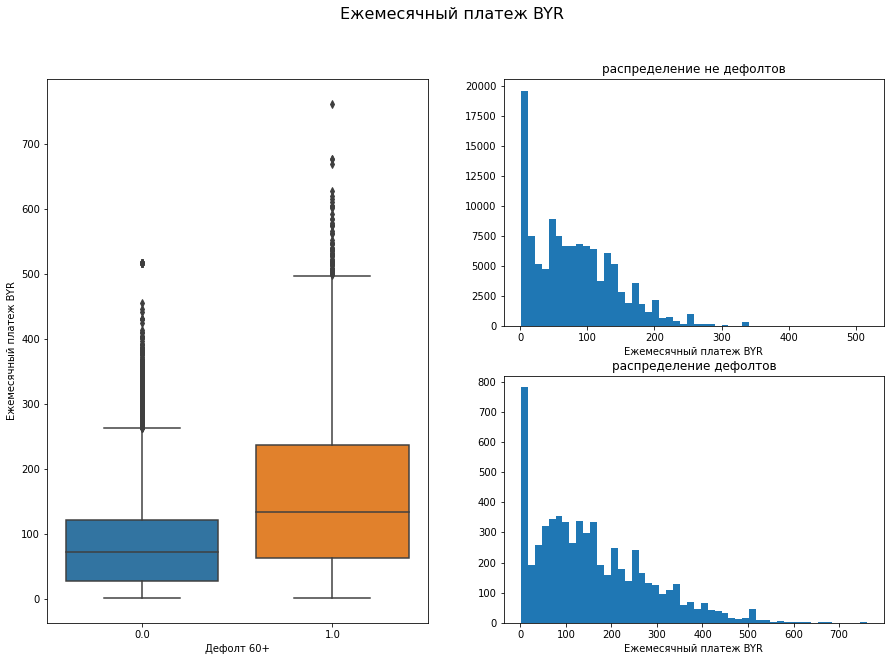

In [7]:
pred_names = ['Возраст', 'Уровень дохода', 'Сумма контракта BYR', 'Кол. обращений в КБ за 30 дн.', 'Кол. действ. кред договоров', 'Число иждивенцев', 'Срок кредита в месяцах','Ежемесячный платеж BYR']

for i, pred in enumerate(number_preds):
    fig = plt.figure(figsize = [15,10])

    ax = plt.subplot(1,2,1)
    sns.boxplot( x = 'default_60+', y = pred, data = data)
    ax.set_xlabel('Дефолт 60+')
    ax.set_ylabel(pred_names[i])

    ax = plt.subplot(2,2,2)
    plt.hist(data.loc[data['default_60+'] == 0, pred], bins = 50)
    ax.set_xlabel(pred_names[i])
    plt.title('распределение не дефолтов')

    ax = plt.subplot(2,2,4)
    plt.hist(data.loc[data['default_60+'] == 1, pred], bins = 50)
    ax.set_xlabel(pred_names[i])
    plt.title('распределение дефолтов')

    fig.suptitle(pred_names[i], fontsize = 16)
    plt.savefig('pirctures/' + pred_names[i] + '.png')
    

#### U критерий Манна-Уитни для сомнительных показателей
#https://pozdniakov.github.io/tidy_stats/ttest.html#nonparam_ttest

In [8]:


print('результат теста для "число обращений в КБ"')
print(sp.stats.mannwhitneyu(data.loc[data['default_60+'] == 0, ['СВ_30_days']], data.loc[data['default_60+'] == 1, ['СВ_30_days']], alternative='less'))

print('результат теста для "количесво иждивенцев"')
print(sp.stats.mannwhitneyu(data.loc[data['default_60+'] == 0, ['dependents_count']], data.loc[data['default_60+'] == 1, ['dependents_count']], alternative='less'))

print('результат теста для "ежемесячный платеж"')
print(sp.stats.mannwhitneyu(data.loc[data['default_60+'] == 0, ['monthly_payment']], data.loc[data['default_60+'] == 1, ['monthly_payment']], alternative='less'))

результат теста для "число обращений в КБ"
MannwhitneyuResult(statistic=array([3.69609837e+08]), pvalue=array([0.22650322]))
результат теста для "количесво иждивенцев"
MannwhitneyuResult(statistic=array([4.02002266e+08]), pvalue=array([1.]))
результат теста для "ежемесячный платеж"
MannwhitneyuResult(statistic=array([2.32945942e+08]), pvalue=array([0.]))


## Проведем исследование номинативных предикторов

In [9]:
nomin_preds = data.columns[(data.dtypes != 'float64') & (np.invert(data.columns.isin(['registration_date', 'repayment_date'])))]
nomin_preds

Index(['sex', 'real_estate', 'Education'], dtype='object')

#### Первым делом построим таблицы сопряженности  и воспользуемся критерием хи квадрат

In [10]:
tables = {}

for pred in nomin_preds:
    tables[pred] = relative_cross_tab_by_rows(data[pred], data['default_60+'])
    print(tables[pred])

          0.0   1.0      0.0%      1.0%
sex                                    
Female  70058  2810  0.961437  0.038563
Male    49357  3414  0.935305  0.064695
               0.0   1.0      0.0%      1.0%
real_estate                                 
No           66808  3550  0.949544  0.050456
Yes          52607  2674  0.951629  0.048371
                        0.0   1.0      0.0%      1.0%
Education                                            
высшее                45863   797  0.982919  0.017081
незаконченное высшее   6330   815  0.885934  0.114066
неполное среднее       3680   360  0.910891  0.089109
среднее               30862  2151  0.934844  0.065156
среднее специальное   32680  2101  0.939593  0.060407


#### Посмотрим по критерию Хи квадрат

In [11]:
for pred in nomin_preds:
    print('==================================')
    simple_chi_sq_test(data.loc[:, pred], data.loc[:, 'default_60+'], data.loc[:, pred].unique())

Нулевую гипотезу следует отклонить. (о равенстве долей в группах)
сравниваемые уровни ['Female' 'Male']
p значение: 0.0
значение статистики: 443.87934687265613
критический уровень: 3.841458820694124
Нельзя отклонить нулевую гипотезу. (о равенстве долей в группах)
сравниваемые уровни ['Yes' 'No']
p значение: 0.09087817233266493
значение статистики: 2.858748619466636
критический уровень: 3.841458820694124
Нулевую гипотезу следует отклонить. (о равенстве долей в группах)
сравниваемые уровни ['среднее специальное' 'высшее' 'среднее' 'незаконченное высшее'
 'неполное среднее']
p значение: 0.0
значение статистики: 2068.447881951081
критический уровень: 9.487729036781154


#### По результатам анализа удалим ряд столбцов

In [12]:
columns_to_drop = ['default_days', 'registration_date','repayment_date', 'contract_summ', 'СВ_30_days', 'real_estate', 'dependents_count', 'month_term'];
data.drop(columns_to_drop, axis = 1, inplace=True)
data.head()

,sex,age,income_level_BYR,force_contract,Education,default_60+,monthly_payment
0,Female,21.0,912.0,0.0,среднее специальное,0.0,52.750217
1,Female,27.0,1045.0,0.0,высшее,0.0,28.139752
2,Female,55.0,1509.0,0.0,среднее,0.0,6.047061
3,Female,40.0,1592.0,0.0,среднее,0.0,159.286313
4,Male,24.0,816.0,2.0,среднее специальное,0.0,100.121299


# Построение модели

### Требуется провести перекодировку номинативных предикторов

In [13]:
# список предикторов подлежащих преобразованию
nomin_preds = data.columns[(data.dtypes != 'float64') & (np.invert(data.columns.isin(['registration_date', 'repayment_date'])))]
print(nomin_preds)

encoder = OneHotEncoder(handle_unknown = 'ignore')

for pred_name in nomin_preds:
    encodet_frame = pd.DataFrame(encoder.fit_transform(data.loc[:,[pred_name]]).toarray(), columns = [pred_name + "_" + lev_name for lev_name in data[pred_name].unique().tolist()]   )
    data = pd.concat([data, encodet_frame], axis = 1)
    
data.drop(nomin_preds, axis = 1, inplace = True)

data.head()

Index(['sex', 'Education'], dtype='object')


,age,income_level_BYR,force_contract,default_60+,monthly_payment,sex_Female,sex_Male,Education_среднее специальное,Education_высшее,Education_среднее,Education_незаконченное высшее,Education_неполное среднее
0,21.0,912.0,0.0,0.0,52.750217,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,27.0,1045.0,0.0,0.0,28.139752,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,55.0,1509.0,0.0,0.0,6.047061,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40.0,1592.0,0.0,0.0,159.286313,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,24.0,816.0,2.0,0.0,100.121299,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Добавим свободный член и исключим те уровни номинативных предикторов которые в него войдут

In [14]:
data.drop(['sex_Female', 'Education_высшее'], axis = 1, inplace = True)
# константа это ничто иное как столбик единичек
data = add_constant(data)

data.head()

,const,age,income_level_BYR,force_contract,default_60+,monthly_payment,sex_Male,Education_среднее специальное,Education_среднее,Education_незаконченное высшее,Education_неполное среднее
0,1.0,21.0,912.0,0.0,0.0,52.750217,0.0,0.0,0.0,0.0,1.0
1,1.0,27.0,1045.0,0.0,0.0,28.139752,0.0,1.0,0.0,0.0,0.0
2,1.0,55.0,1509.0,0.0,0.0,6.047061,0.0,0.0,0.0,1.0,0.0
3,1.0,40.0,1592.0,0.0,0.0,159.286313,0.0,0.0,0.0,1.0,0.0
4,1.0,24.0,816.0,2.0,0.0,100.121299,1.0,0.0,0.0,0.0,1.0


### Разбиение выборки на обучающую и валидационную

In [15]:
[train_data, test_data] = train_test_split(data, test_size = 0.3, train_size = 0.7,random_state=4)

### Оценка коэффициентов модели 

In [16]:
model = Logit(train_data.loc[:,'default_60+'], train_data.loc[:,train_data.columns != 'default_60+']).fit()
model.summary2()

Optimization terminated successfully.
         Current function value: 0.102418
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                    Logit                Pseudo R-squared:     0.476     
Dependent Variable:       default_60+          AIC:                  18034.7480
Date:                     2021-12-13 10:40     BIC:                  18128.5929
No. Observations:         87947                Log-Likelihood:       -9007.4   
Df Model:                 9                    LL-Null:              -17183.   
Df Residuals:             87937                LLR p-value:          0.0000    
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           10.0000                                              
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
const                           2.3088   0.1271  18.1697 0.0000  2.0598  2.5579
age                            -0.0914   0.0042 -21.6166 0.0000 -0.0997 -0.0831
income_level_BYR               -0.0032   0.0001 -42.6713 0.0000 -0.0034 -0.0031
force_contract                  0.4605   0.0086  53.5508 0.0000  0.4436  0.4773
monthly_payment                 0.0077   0.0002  35.5292 0.0000  0.0072  0.0081
sex_Male                        0.3825   0.0402   9.5108 0.0000  0.3037  0.4613
Education_среднее специальное  -1.6175   0.0779 -20.7646 0.0000 -1.7702 -1.4649
Education_среднее              -0.2240   0.1070  -2.0937 0.0363 -0.4336 -0.0143
Education_незаконченное высшее -0.5040   0.0695  -7.2524 0.0000 -0.6403 -0.3678
Education_неполное среднее     -0.6138   0.0697  -8.8010 0.0000 -0.7505 -0.4771
===============================================================================

"""

#### Оценка качесва модели

получим предсказания для тестовой выборки

In [17]:
pred_probs = model.predict(test_data.loc[:,test_data.columns != 'default_60+'])
pred_probs

123926    0.001623
18715     0.259532
76208     0.008139
46023     0.000338
22364     0.003402
            ...   
40652     0.003876
45875     0.003583
78242     0.000732
81273     0.004755
48334     0.000395
Length: 37692, dtype: float64

получено значение AUC0.9567039019111782


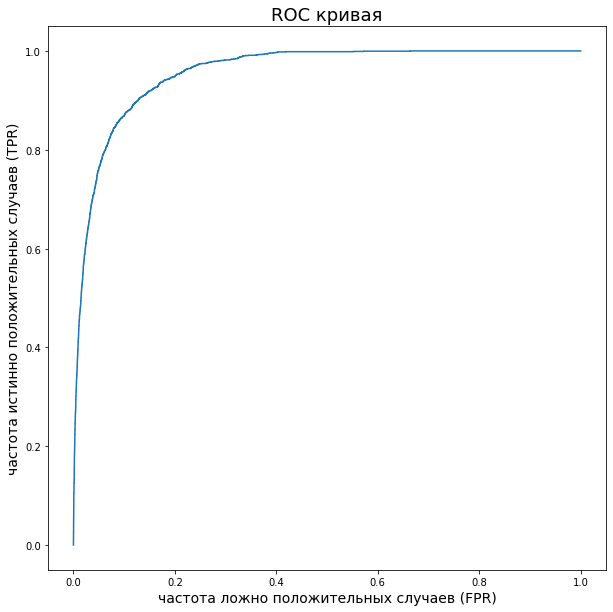

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(test_data.loc[:,'default_60+'], pred_probs )

plt.figure(figsize = [10,10])
plt.plot(fpr, tpr)

plt.ylabel('частота истинно положительных случаев (TPR)', fontsize = 14)
plt.xlabel('частота ложно положительных случаев (FPR)', fontsize = 14)
plt.title('ROC кривая', fontsize = 18)

plt.savefig('pirctures/ROC.png')

AUC = metrics.roc_auc_score( test_data.loc[:,'default_60+'],pred_probs)
print('получено значение AUC' + str(AUC))

Получение точки отсечения - в соответвии с текущей политикой банка предусматривается чтобы ошибка при клсасси

In [51]:
tepm_table = pd.DataFrame({'точка отчечения' : thresholds  , 'Доля ошибочно отнесенных к дефолту': fpr*100, 'Доля правильно отнесенных к дефолту': tpr*100, 'Доля правильно отнесенных к не дефолту': (1-fpr)*100, 'Доля ошибочно отнесенных к не дефолту': (1-tpr)*100})
tepm_table.to_excel('Logit_validation.xlsx')